# Downloading and spliting Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ricardosalvatorelli1/paddydoctor")

print("Path to dataset files:", path)


100%|██████████| 1.02G/1.02G [00:10<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/root/.cache/kagglehub/datasets/ricardosalvatorelli1/paddydoctor/versions/1/train_images'
output_dir = 'split_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create directories for split dataset
def create_dir_structure():
    for split_dir in [train_dir, val_dir, test_dir]:
        os.makedirs(split_dir, exist_ok=True)

# Split dataset
def split_dataset():
    create_dir_structure()

    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        # Get all image file paths in the current class folder
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        # Split data into train (70%), temp (30%)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)

        # Further split temp into validation (10%) and test (20%)
        val_images, test_images = train_test_split(temp_images, test_size=2/3, random_state=42)

        # Move images to respective directories
        for image in train_images:
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in val_images:
            dest_dir = os.path.join(val_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

        for image in test_images:
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.move(image, dest_dir)

# Run the script
if __name__ == '__main__':
    split_dataset()
    print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


In [ ]:
train_path  = "split_dataset/train/"
test_path  = "split_dataset/test/"
val_path  = "split_dataset/val/"
import glob
from pathlib import Path


print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('val images')
for filepath in glob.glob(val_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")


train images
1115 	 hispa
1234 	 normal
235 	 bacterial_panicle_blight
335 	 bacterial_leaf_blight
1009 	 dead_heart
761 	 tungro
1216 	 blast
266 	 bacterial_leaf_streak
434 	 downy_mildew
675 	 brown_spot
test images
320 	 hispa
354 	 normal
68 	 bacterial_panicle_blight
96 	 bacterial_leaf_blight
289 	 dead_heart
218 	 tungro
348 	 blast
76 	 bacterial_leaf_streak
124 	 downy_mildew
194 	 brown_spot
val images
159 	 hispa
176 	 normal
34 	 bacterial_panicle_blight
48 	 bacterial_leaf_blight
144 	 dead_heart
109 	 tungro
174 	 blast
38 	 bacterial_leaf_streak
62 	 downy_mildew
96 	 brown_spot


# Model Initialization and Training

In [ ]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [ ]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

    opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

# plot_model(model, '/kaggle/working/model.png', show_shapes=True)

channels_last


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


DataLoader

In [ ]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(
    directory=val_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 5827 images belonging to 10 classes.
Found 202 images belonging to 10 classes.
Found 2087 images belonging to 10 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
2087


In [ ]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=EPOCHS)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 125s 586ms/step - accuracy: 0.2310 - loss: 0.6124 - val_accuracy: 0.1719 - val_loss: 7.5505
Epoch 2/50
  1/182 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3750 - loss: 0.2651

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3750 - loss: 0.2651 - val_accuracy: 0.0000e+00 - val_loss: 9.7046
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 114s 535ms/step - accuracy: 0.3829 - loss: 0.3035 - val_accuracy: 0.2031 - val_loss: 0.8495
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3750 - loss: 0.2943 - val_accuracy: 0.1000 - val_loss: 1.0803
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 98s 522ms/step - accuracy: 0.4755 - loss: 0.2700 - val_accuracy: 0.4375 - val_loss: 0.3188
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5625 - loss: 0.2710 - val_accuracy: 0.3000 - val_loss: 0.3720
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 142s 524ms/step - accuracy: 0.5422 - loss: 0.2353 - val_accuracy: 0.5833 - val_loss: 0.2211
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 0.2728 - val_accuracy: 0.5000 - val_loss: 0.2216
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 143s 524ms/step - accuracy: 0.5901 - loss: 0.2142 - val

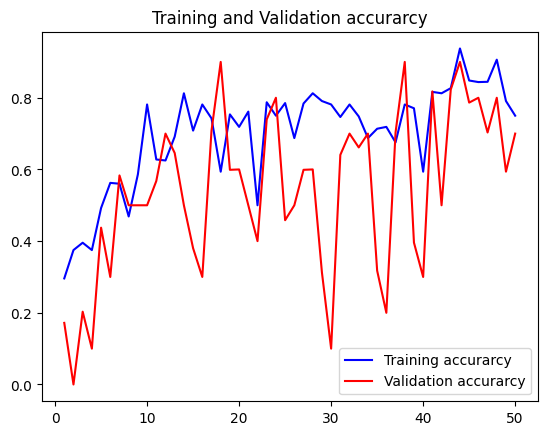

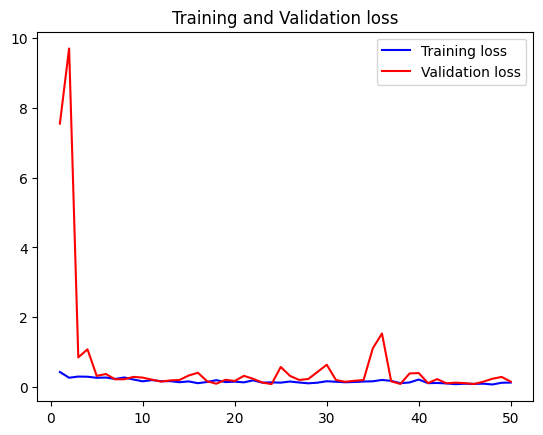

CPU times: user 452 ms, sys: 105 ms, total: 556 ms
Wall time: 570 ms


In [ ]:
%%time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# Model Testing

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step


In [ ]:
loss, acc = model.evaluate(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

2087/2087 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5577 - loss: 0.3144
0.5855294466018677 0.27283185720443726


In [ ]:
pd.Series(train_generator.classes).value_counts()

,count
8,988
3,973
7,892
5,808
9,609
4,540
6,348
0,268
1,213
2,188


In [ ]:
pd.Series(test_generator.classes).value_counts()

,count
8,354
3,348
7,320
5,289
9,218
4,194
6,124
0,96
1,76
2,68


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
blast,575
hispa,441
normal,427
dead_heart,411
downy_mildew,59
bacterial_leaf_blight,46
bacterial_panicle_blight,38
tungro,31
bacterial_leaf_streak,30
brown_spot,29


In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100133.jpg,normal
1,bacterial_leaf_blight/100268.jpg,hispa
2,bacterial_leaf_blight/100330.jpg,normal
3,bacterial_leaf_blight/100382.jpg,hispa
4,bacterial_leaf_blight/100447.jpg,blast
